# Load Prediction

In [ ]:

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Couldn't import dot_parser, loading of dot files will not be possible.


In [ ]:
df = pd.read_csv("energy_dataset.csv")

In [3]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0000,329.0000,0.0000,4844.0000,4821.0000,162.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,6378.0000,17.0000,NaN,6436.0000,26118.0000,25385.0000,50.1000,65.4100
1,2015-01-01 01:00:00+01:00,449.0000,328.0000,0.0000,5196.0000,4755.0000,158.0000,0.0000,0.0000,0.0000,...,195.0000,0.0000,5890.0000,16.0000,NaN,5856.0000,24934.0000,24382.0000,48.1000,64.9200
2,2015-01-01 02:00:00+01:00,448.0000,323.0000,0.0000,4857.0000,4581.0000,157.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,5461.0000,8.0000,NaN,5454.0000,23515.0000,22734.0000,47.3300,64.4800
3,2015-01-01 03:00:00+01:00,438.0000,254.0000,0.0000,4314.0000,4131.0000,160.0000,0.0000,0.0000,0.0000,...,191.0000,0.0000,5238.0000,2.0000,NaN,5151.0000,22642.0000,21286.0000,42.2700,59.3200
4,2015-01-01 04:00:00+01:00,428.0000,187.0000,0.0000,4130.0000,3840.0000,156.0000,0.0000,0.0000,0.0000,...,189.0000,0.0000,4935.0000,9.0000,NaN,4861.0000,21785.0000,20264.0000,38.4100,56.0400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [ ]:
temp = df.copy() 
dataset = temp['total load actual'].dropna().values 
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset) 

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


In [ ]:
# LSTM

temp = df
dataset = temp['total load actual'].dropna().values 
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [8]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

Epoch 1/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0271 - val_loss: 0.0029
Epoch 2/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 3/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 4/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 5/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 7/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - val_loss: 9.1829e-04
Epoch 8/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - val_loss: 8.9800e-04
Epoch 9/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.0017 - val_loss: 8.7233e-04
Epoch 10/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0017 - val_loss: 8.9542e-04
Epoch 11/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016 - val_loss: 8.5000e-04
Epoch 12/200
400/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,505 (591.82 KB)

 Trainable params: 50,501 (197.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,004 (394.55 KB)

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
Train Mean Absolute Error: 362.5518168409812
Train Root Mean Squared Error: 578.9294557458384
Test Mean Absolute Error: 341.1394280661877
Test Root Mean Squared Error: 544.8755847672959


In [10]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

Train MAPE: 1.2949869234931788, Test MAPE: 1.2111347990185775


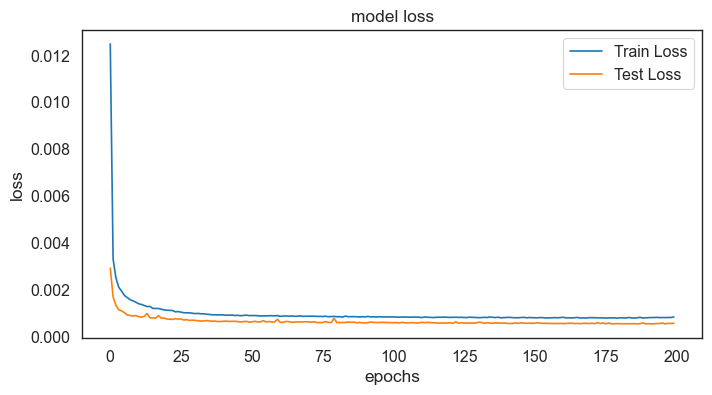

In [11]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

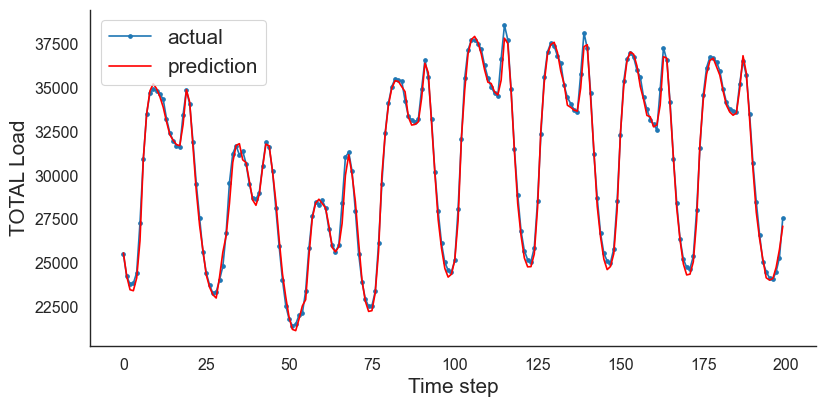

In [ ]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

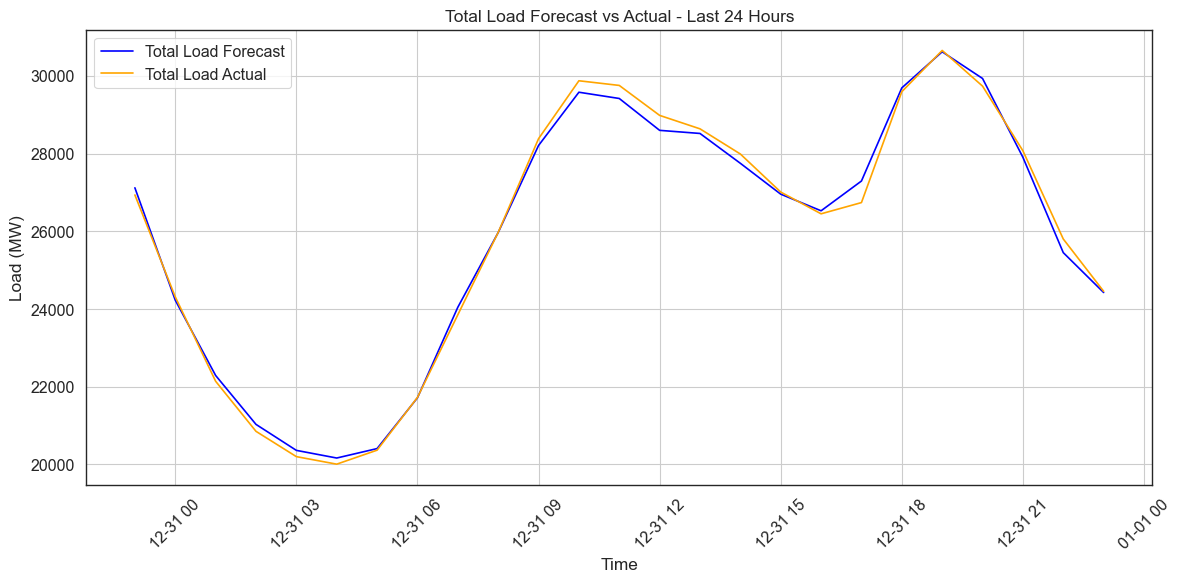

In [ ]:

data = pd.read_csv('updated_energy_dataset.csv')

data['time'] = pd.to_datetime(data['time'])


end_time = data['time'].max()  
start_time = end_time - pd.Timedelta(hours=24) 

last_24_hours_data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

total_load_forecast = last_24_hours_data['total load forecast']
total_load_actual = last_24_hours_data['total load actual']
time = last_24_hours_data['time']  

plt.figure(figsize=(12, 6))
plt.plot(time, total_load_forecast, label='Total Load Forecast', color='blue')
plt.plot(time, total_load_actual, label='Total Load Actual', color='orange')


plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Total Load Forecast vs Actual - Last 24 Hours')
plt.legend()  
plt.grid()
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()


# Optimization

In [ ]:
from datetime import timedelta

ev_data = pd.read_csv('vehicle_data_with_time_availability.csv')
grid_data = pd.read_csv('last_day_dataset.csv')

grid_data['time'] = pd.to_datetime(grid_data['time'])
ev_data['Charging Start Time'] = pd.to_datetime(ev_data['Charging Start Time'])

# Filter out vehicles that do not have a Vehicle Model
ev_data = ev_data[ev_data['Vehicle Model'].notna()]

# Fill NaN in User Time Availability with a default value (e.g., 1 hour) to avoid NaN errors
ev_data['User Time Availability'] = ev_data['User Time Availability'].fillna(1.0)

# Create a time series from 2018-12-30 22:00:00 to 2018-12-31 22:00:00 with a 5-minute interval
time_series = pd.date_range(start='2018-12-30 22:00:00+00:00', 
                            end='2018-12-31 22:00:00+00:00', freq='5T')

# Initialize an empty dataframe with times as index and vehicle users as columns
output_df = pd.DataFrame(index=time_series)

# Sort EV data by Charging Start Time and assign a unique user label for each vehicle
ev_data = ev_data.sort_values(by='Charging Start Time').reset_index(drop=True)
ev_data['user'] = ['user' + str(i + 1) for i in range(len(ev_data))]

# Define placeholders for total calculations
total_ev_load = np.zeros(len(time_series))
total_ev_load_no_opt = np.zeros(len(time_series))  # New array for unoptimized load
user_power_consumed = []
state_of_charge_end = []

# Process each vehicle
for idx, vehicle in ev_data.iterrows():
    # Vehicle info
    start_time = vehicle['Charging Start Time']
    user_time_avail = vehicle['User Time Availability'] * 60  # convert to minutes
    battery_capacity = vehicle['Battery Capacity (kWh)']
    state_of_charge_start = vehicle['State of Charge (Start %)'] / 100
    battery_health = vehicle['Battery Health'] / 100

    # Create charging schedule (linear charging as an example)
    end_time = start_time + timedelta(minutes=user_time_avail)
    charge_times = pd.date_range(start=start_time, end=end_time, freq='5T', closed='left')
    
    # Define charging rates (flexible charging rates from 0 to 30 kW)
    charge_rate = np.round(np.linspace(5, 30, len(charge_times)), 1)  # Charging from 5 to 30 kW

    # Initialize user row and SOC for this vehicle
    user_row = np.zeros(len(time_series))
    current_soc = state_of_charge_start * battery_capacity  # Current stored energy in kWh

    # Update the charging/discharging rates in the row corresponding to the vehicle
    for i, charge_time in enumerate(charge_times):
        if charge_time in output_df.index:
            time_idx = output_df.index.get_loc(charge_time)

            # Determine if charging or discharging
            if current_soc < battery_capacity:  # Charge only if the battery is not full
                user_row[time_idx] = charge_rate[i]  # Positive for charging
                current_soc += charge_rate[i] * (5 / 60)  # Increase SOC based on charging
            else:  # If battery is full, simulate discharge to manage load
                user_row[time_idx] = -charge_rate[i] * battery_health  # Negative for discharging
                current_soc -= charge_rate[i] * battery_health * (5 / 60)  # Decrease SOC based on discharging

            # Update total EV load
            total_ev_load[time_idx] += user_row[time_idx]

    # Calculate final SOC (end %)
    state_of_charge_end.append(min(current_soc / battery_capacity * 100, 100))  # Max 100%

    # Calculate total energy consumed (positive or negative depending on charge/discharge)
    user_power_consumed.append(np.round(np.sum(user_row[user_row > 0]) * (5 / 60), 1))  # Total kWh charged

    # Add the row to the output dataframe
    output_df[vehicle['user']] = user_row

    # Unoptimized EV load calculation (charging at a fixed rate of 30 kW until full)
    current_soc_no_opt = state_of_charge_start * battery_capacity  # Reset SOC for unoptimized
    for charge_time in charge_times:
        if charge_time in output_df.index:
            time_idx = output_df.index.get_loc(charge_time)

            if current_soc_no_opt < battery_capacity:  # Charge only if the battery is not full
                total_ev_load_no_opt[time_idx] += 30  # Charging at a fixed rate of 30 kW
                current_soc_no_opt += 30 * (5 / 60)  # Increase SOC based on charging

# Round the user rows for discharging values to one decimal place
output_df[output_df < 0] = np.round(output_df[output_df < 0], 1)

# Add the total rows for EV load and grid load without EV
output_df['Total EV Load'] = total_ev_load
output_df['Total EV Load (No Optimization)'] = total_ev_load_no_opt  # New column for unoptimized load
output_df['Total Load without EV'] = np.repeat(grid_data['total load without ev'].values, len(time_series) // len(grid_data))
output_df['Total Load with EV'] = output_df['Total EV Load'] + output_df['Total Load without EV']
output_df['Total Load with EV (No Optimization)'] = output_df['Total EV Load (No Optimization)'] + output_df['Total Load without EV']  # New column for unoptimized total load

# Round total load values to one decimal place
output_df['Total EV Load'] = np.round(output_df['Total EV Load'], 1)
output_df['Total EV Load (No Optimization)'] = np.round(output_df['Total EV Load (No Optimization)'], 1)
output_df['Total Load without EV'] = np.round(output_df['Total Load without EV'], 1)
output_df['Total Load with EV'] = np.round(output_df['Total Load with EV'], 1)
output_df['Total Load with EV (No Optimization)'] = np.round(output_df['Total Load with EV (No Optimization)'], 1)

# Adding Power Consumed and State of Charge (End %) rows at the end
# Ensure the length matches the number of users (columns)
output_df.loc['Power Consumed'] = pd.Series(np.round(user_power_consumed, 1), index=output_df.columns[:len(user_power_consumed)])
output_df.loc['State of Charge (End %)'] = pd.Series(np.round(state_of_charge_end, 1), index=output_df.columns[:len(state_of_charge_end)])

# Save the final dataset
output_df.to_csv('ev_optimization.csv', index=True)

print("Optimization completed and saved as ev_optimization.csv")


Optimization completed and saved as ev_optimization.csv


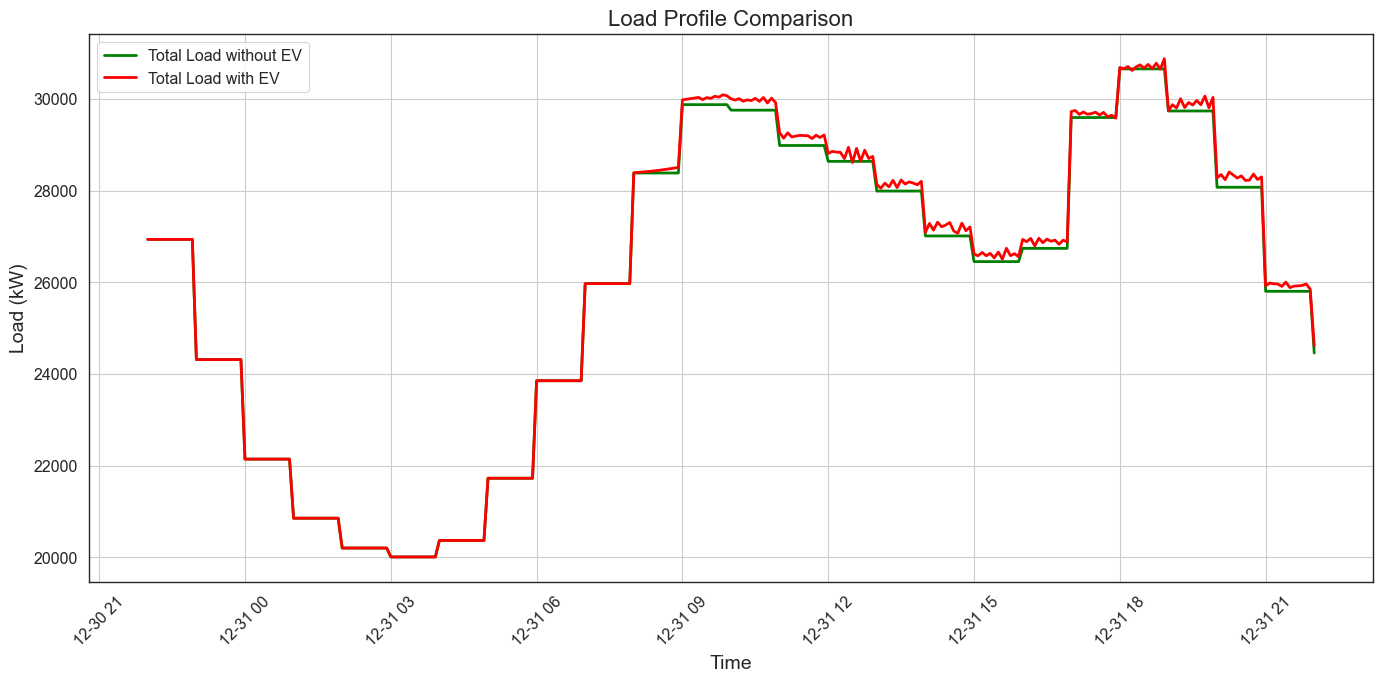

In [ ]:

# Load the final optimized dataset
output_df = pd.read_csv('final_ev_optimization_transposed.csv', index_col=0)

output_df.index = pd.to_datetime(output_df.index, errors='coerce')

output_df = output_df.dropna()

plt.figure(figsize=(14, 7))
plt.plot(output_df.index, output_df['Total Load without EV'], label='Total Load without EV', color='green', linewidth=2)
plt.plot(output_df.index, output_df['Total Load with EV'], label='Total Load with EV', color='red', linewidth=2)

plt.title('Load Profile Comparison', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Load (kW)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


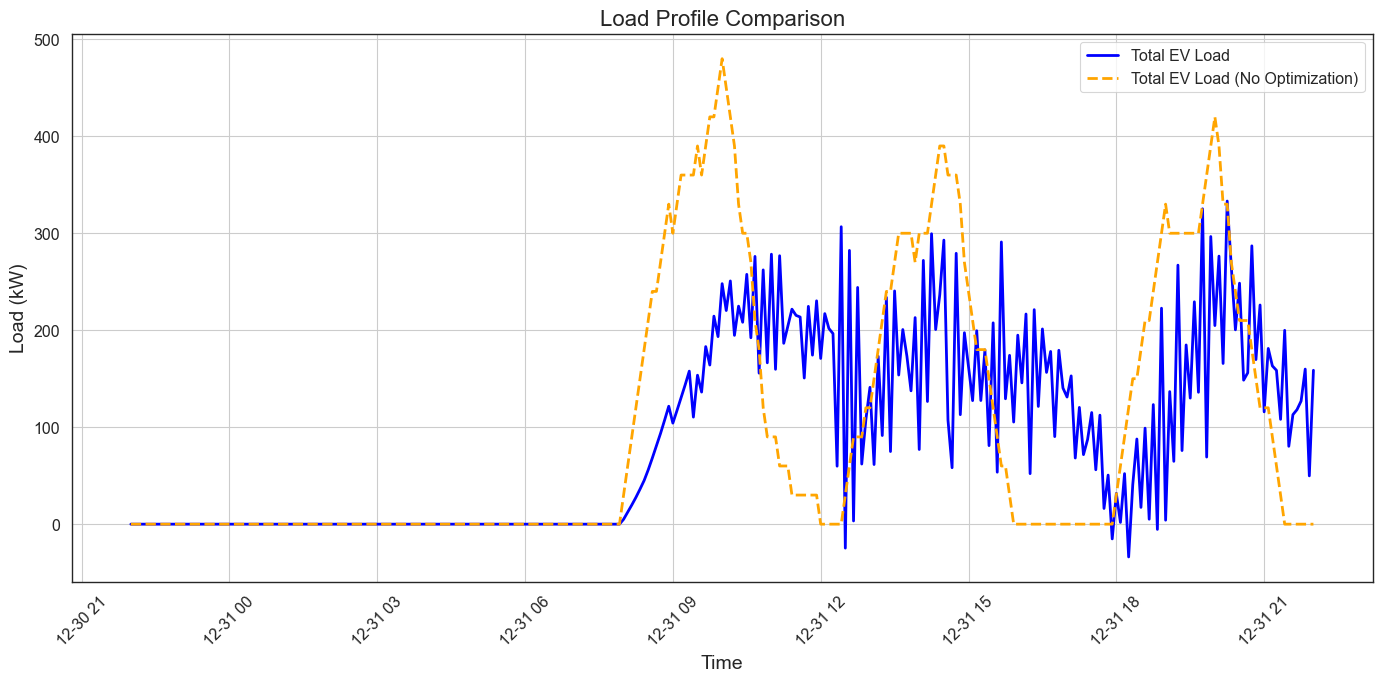

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the final optimized dataset
output_df = pd.read_csv('final_ev_optimization_transposed.csv', index_col=0)

# Try to convert the index to datetime, using errors='coerce' to handle problematic entries
output_df.index = pd.to_datetime(output_df.index, errors='coerce')

# Drop rows where index conversion failed (if any)
output_df = output_df.dropna()

# Plotting the different loads
plt.figure(figsize=(14, 7))
plt.plot(output_df.index, output_df['Total EV Load'], label='Total EV Load', color='blue', linewidth=2)
plt.plot(output_df.index, output_df['Total EV Load (No Optimization)'], label='Total EV Load (No Optimization)', color='orange', linestyle='--', linewidth=2)


# Adding title and labels
plt.title('Load Profile Comparison', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Load (kW)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


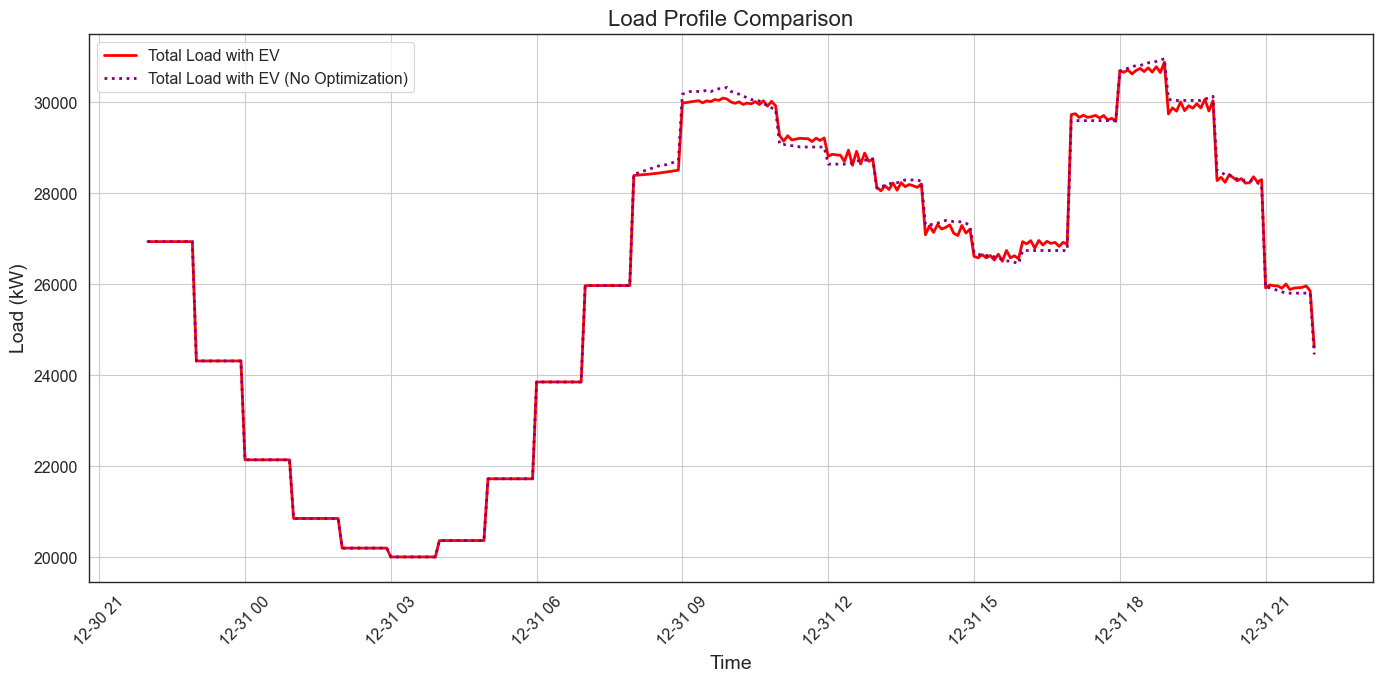

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the final optimized dataset
output_df = pd.read_csv('final_ev_optimization_transposed.csv', index_col=0)

# Try to convert the index to datetime, using errors='coerce' to handle problematic entries
output_df.index = pd.to_datetime(output_df.index, errors='coerce')

# Drop rows where index conversion failed (if any)
output_df = output_df.dropna()

# Plotting the different loads
plt.figure(figsize=(14, 7))
plt.plot(output_df.index, output_df['Total Load with EV'], label='Total Load with EV', color='red', linewidth=2)
plt.plot(output_df.index, output_df['Total Load with EV (No Optimization)'], label='Total Load with EV (No Optimization)', color='purple', linestyle=':', linewidth=2)

# Adding title and labels
plt.title('Load Profile Comparison', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Load (kW)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


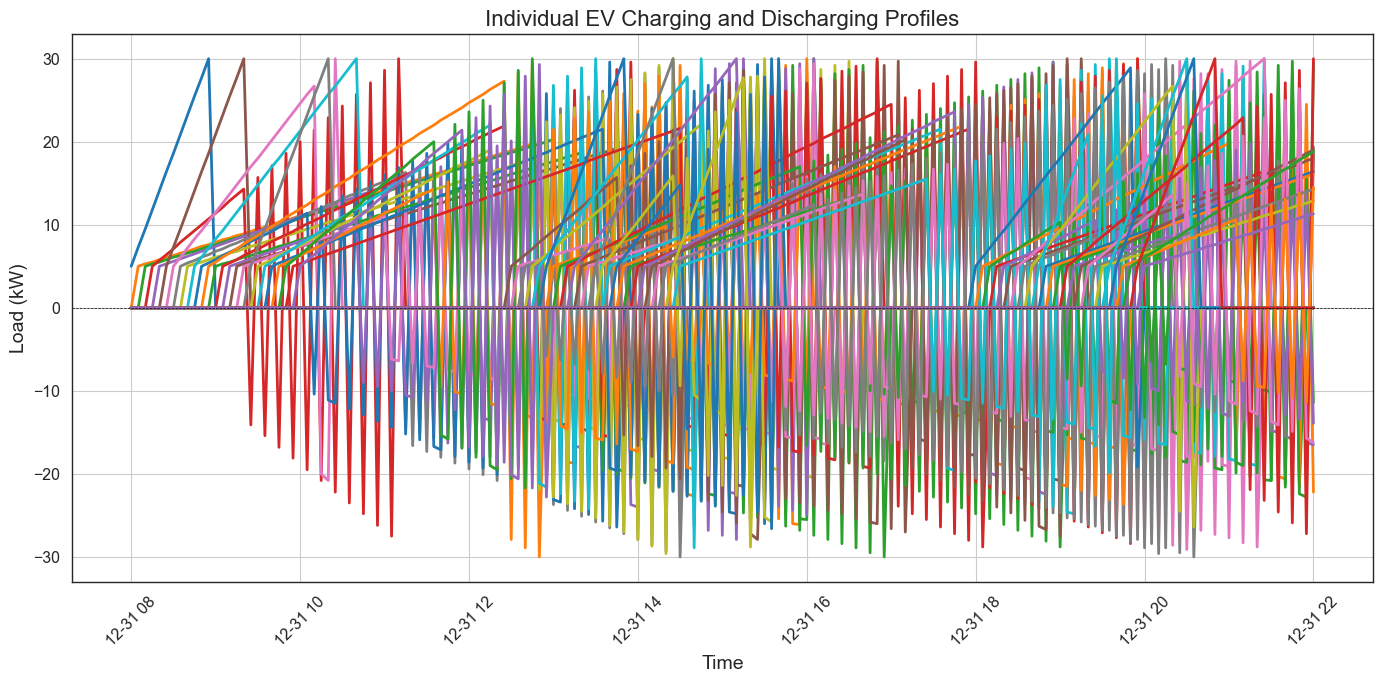

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the final optimized dataset
output_df = pd.read_csv('final_ev_optimization_transposed.csv', index_col=0)

# Convert the index to datetime, using errors='coerce' to handle problematic entries
output_df.index = pd.to_datetime(output_df.index, errors='coerce')

# Drop rows where index conversion failed (if any)
output_df = output_df.dropna()

# Filter the DataFrame to start from the given timestamp
start_time = pd.to_datetime('2018-12-31 08:00:00+00:00')
output_df = output_df[output_df.index >= start_time]

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Get only the user columns (excluding total load columns)
user_columns = output_df.columns[:-5]  # Adjusting the number to exclude last 5 columns (total loads)

# Loop through each user (vehicle) in the DataFrame
for user in user_columns:
    plt.plot(output_df.index, output_df[user], linewidth=2)

# Adding title and labels
plt.title('Individual EV Charging and Discharging Profiles', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Load (kW)', fontsize=14)
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Line at y=0 for reference
# Remove the legend
# plt.legend()  # Commented out

plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


# Smoothening

In [21]:
import pandas as pd

# Load the dataset
data = pd.read_csv('ev_optimization.csv')

# Rename 'Unnamed: 0' to 'Time'
data = data.rename(columns={'Unnamed: 0': 'Time'})

# Separate rows with actual datetime values in 'Time'
# We assume entries with 'Power Consumed' or similar labels in 'Time' are at the end.
data_main = data[pd.to_datetime(data['Time'], errors='coerce').notna()].copy()
data_summary = data[pd.to_datetime(data['Time'], errors='coerce').isna()].copy()

# Convert 'Time' column in main data to datetime
data_main['Time'] = pd.to_datetime(data_main['Time'])

# Step 1: Smoothing Individual Profiles (Using Rolling Average)
ev_columns = [col for col in data_main.columns if 'user' in col]  # Columns containing individual user data
for col in ev_columns:
    data_main[col] = data_main[col].rolling(window=3, min_periods=1).mean()  # Adjust window size as needed

# Step 2: Calculate Total EV Load (After Optimization)
data_main['Total EV Load'] = data_main[ev_columns].sum(axis=1)

# Step 3: Recalculate Total Load with EV (After Optimization)
data_main['Total Load with EV'] = data_main['Total Load without EV'] + data_main['Total EV Load']

# Combine the processed main data and summary rows (if needed)
data_processed = pd.concat([data_main, data_summary], ignore_index=True)

# Save the optimized data back to a CSV file
data_processed.to_csv('ev_optimization_smoothed.csv', index=False)


                         Time   user1    user2    user3    user4    user5  \
0   2018-12-30 22:00:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
1   2018-12-30 22:05:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
2   2018-12-30 22:10:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
3   2018-12-30 22:15:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
4   2018-12-30 22:20:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
..                        ...     ...      ...      ...      ...      ...   
286 2018-12-31 21:50:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
287 2018-12-31 21:55:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
288 2018-12-31 22:00:00+00:00  0.0000   0.0000   0.0000   0.0000   0.0000   
289                       NaT 17.5000  96.4000  98.0000  32.2000  75.2000   
290                       NaT 70.7000 100.0000 100.0000 100.0000 100.0000   

       user6    user7   user8    user9  ...  user71   user72  user73  user7

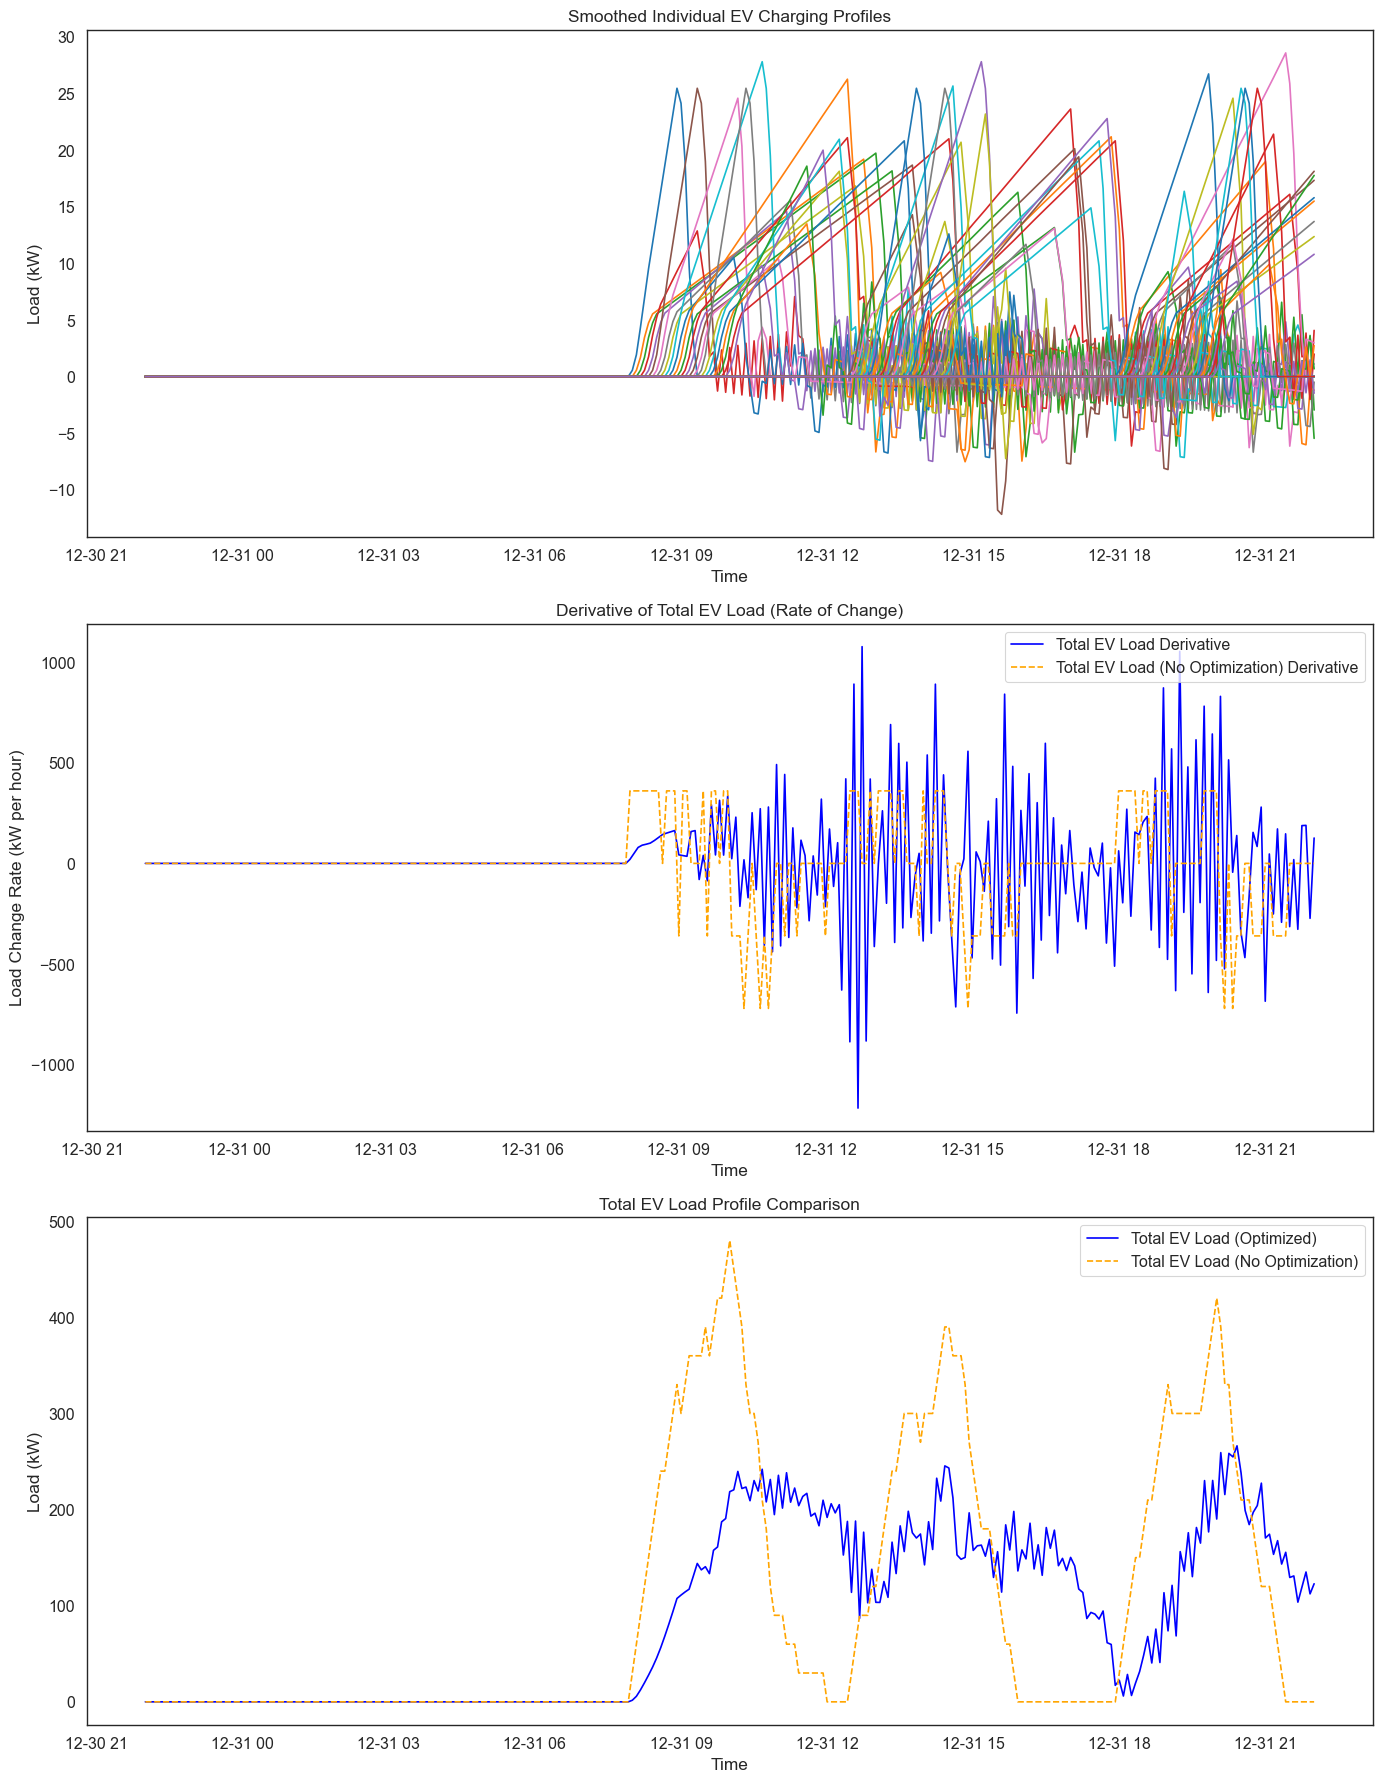

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset (replace with the actual file path if needed)
data = pd.read_csv('ev_optimization_smoothed.csv', on_bad_lines='skip')  # Adjust the file name accordingly

# Rename the first unnamed column to 'Time'
data.columns = ['Time'] + list(data.columns[1:])  # Assign 'Time' to the first column and leave the rest intact

# Convert 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'], errors='coerce')

# Check for non-datetime entries in 'Time'
non_date_entries = data[~data['Time'].apply(lambda x: isinstance(x, str) and pd.to_datetime(x, errors='coerce') is not pd.NaT)]
print(non_date_entries)  # Inspect non-datetime entries

# Remove rows with non-datetime values in 'Time'
data = data[pd.to_datetime(data['Time'], errors='coerce').notna()]

# Convert 'Time' column to datetime again (if needed)
data['Time'] = pd.to_datetime(data['Time'])

# Step 1: Smoothing Individual Profiles (Using Rolling Average)
# For each individual EV column, we apply a rolling average with a window of 5 minutes (or adjust as needed).
ev_columns = [col for col in data.columns if 'user' in col]  # Example, if users are labeled as 'user1', 'user2', etc.
for col in ev_columns:
    data[f'{col}_smoothed'] = data[col].rolling(window=3, min_periods=1).mean()  # Adjust window size as needed

# Step 2: Calculate Derivative of Total EV Load (Optimized and Non-Optimized)
# Derivative represents the rate of change; this can help to see how the load fluctuates over time.
data['Total EV Load Derivative'] = data['Total EV Load'].diff() / (data['Time'].diff().dt.total_seconds() / 3600)  # kW per hour
data['Total EV Load (No Optimization) Derivative'] = data['Total EV Load (No Optimization)'].diff() / (data['Time'].diff().dt.total_seconds() / 3600)

# Step 3: Efficiency Metrics Calculation
# Metrics: Peak reduction, variance reduction, and average load
peak_before = data['Total EV Load (No Optimization)'].max()
peak_after = data['Total EV Load'].max()
variance_before = data['Total EV Load (No Optimization)'].var()
variance_after = data['Total EV Load'].var()
average_before = data['Total EV Load (No Optimization)'].mean()
average_after = data['Total EV Load'].mean()

peak_reduction = (peak_before - peak_after) / peak_before * 100
variance_reduction = (variance_before - variance_after) / variance_before * 100

print("Metrics:")
print(f"Peak Load Reduction: {peak_reduction:.2f}%")
print(f"Variance Reduction: {variance_reduction:.2f}%")
print(f"Average Load Before Optimization: {average_before:.2f} kW")
print(f"Average Load After Optimization: {average_after:.2f} kW")

# Step 4: Visualization
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Plot 1: Smoothed Individual EV Charging Profiles
for col in ev_columns:
    axs[0].plot(data['Time'], data[f'{col}_smoothed'])  # Removed label parameter
axs[0].set_title('Smoothed Individual EV Charging Profiles')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Load (kW)')

# Plot 2: Derivative Comparison (Optimized vs Non-Optimized)
axs[1].plot(data['Time'], data['Total EV Load Derivative'], color='blue', label='Total EV Load Derivative')
axs[1].plot(data['Time'], data['Total EV Load (No Optimization) Derivative'], color='orange', linestyle='--', label='Total EV Load (No Optimization) Derivative')
axs[1].set_title('Derivative of Total EV Load (Rate of Change)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Load Change Rate (kW per hour)')
axs[1].legend(loc='upper right')

# Plot 3: Load Profile Comparison
axs[2].plot(data['Time'], data['Total EV Load'], color='blue', label='Total EV Load (Optimized)')
axs[2].plot(data['Time'], data['Total EV Load (No Optimization)'], color='orange', linestyle='--', label='Total EV Load (No Optimization)')
axs[2].set_title('Total EV Load Profile Comparison')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Load (kW)')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

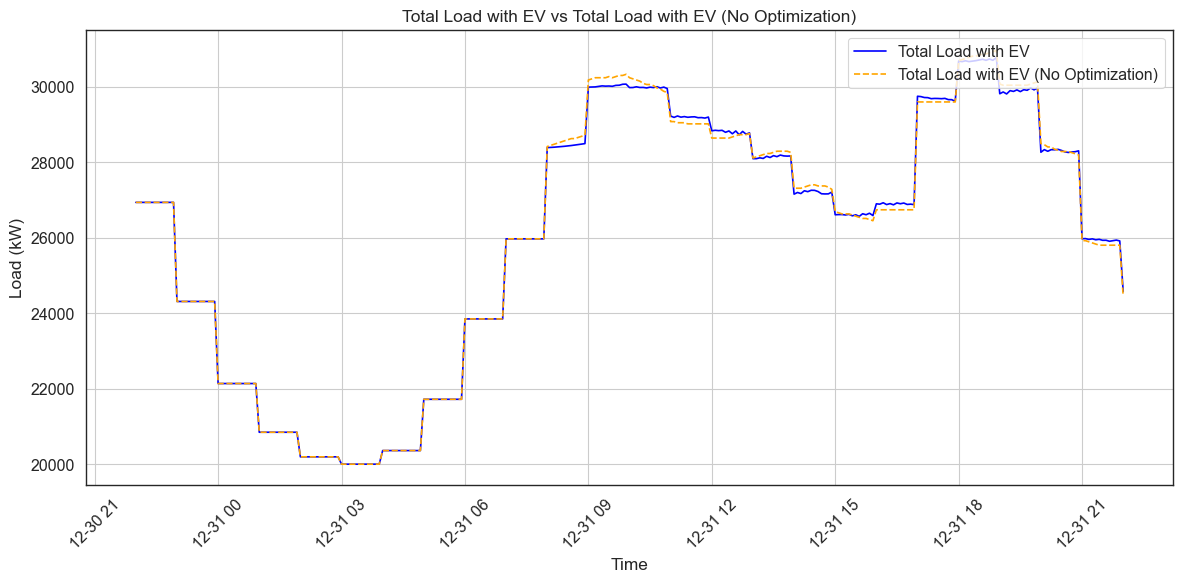

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and rename columns
data = pd.read_csv('ev_optimization.csv')
data = data.rename(columns={'Unnamed: 0': 'Time'})

# Separate rows with actual datetime values in 'Time'
data_main = data[pd.to_datetime(data['Time'], errors='coerce').notna()].copy()
data_summary = data[pd.to_datetime(data['Time'], errors='coerce').isna()].copy()

# Convert 'Time' column in main data to datetime
data_main['Time'] = pd.to_datetime(data_main['Time'])

# Step 1: Smoothing Individual Profiles (Using Rolling Average)
ev_columns = [col for col in data_main.columns if 'user' in col]  # Columns containing individual user data
for col in ev_columns:
    data_main[col] = data_main[col].rolling(window=3, min_periods=1).mean()  # Adjust window size as needed

# Step 2: Calculate Total EV Load (After Optimization)
data_main['Total EV Load'] = data_main[ev_columns].sum(axis=1)

# Step 3: Recalculate Total Load with EV (After Optimization)
data_main['Total Load with EV'] = data_main['Total Load without EV'] + data_main['Total EV Load']

# Combine the processed main data and summary rows (if needed)
data_processed = pd.concat([data_main, data_summary], ignore_index=True)

# Filter out rows where Time is not a datetime for plotting
data_filtered = data_processed[pd.to_datetime(data_processed['Time'], errors='coerce').notna()]

# Step 4: Plotting Total Load with EV and Total Load with EV (No Optimization)
plt.figure(figsize=(12, 6))

# Plot Total Load with EV
plt.plot(data_filtered['Time'], data_filtered['Total Load with EV'], label='Total Load with EV', color='blue')

# Plot Total Load with EV (No Optimization)
plt.plot(data_filtered['Time'], data_filtered['Total Load with EV (No Optimization)'], label='Total Load with EV (No Optimization)', color='orange', linestyle='--')

# Add titles and labels
plt.title('Total Load with EV vs Total Load with EV (No Optimization)')
plt.xlabel('Time')
plt.ylabel('Load (kW)')
plt.legend(loc='upper right')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.grid()  # Add a grid for better visibility

# Show the plot
plt.show()


# Pricing

In [26]:
# Load the existing output dataset
output_df = pd.read_csv('ev_optimization_smoothed.csv', index_col=0)

# Set pricing variables
base_rate_per_kwh = 0.20  # Base rate in currency per kWh
peak_multiplier = 1.5     # Multiplier for peak time
discharge_discount_per_kwh = 0.10  # Discount per kWh discharged during peak

# Identify peak and non-peak times based on Total Load without EV
peak_threshold = output_df['Total Load without EV'].mean() + output_df['Total Load without EV'].std()
output_df['Time Period'] = output_df['Total Load without EV'].apply(lambda x: 'peak' if x >= peak_threshold else 'off-peak')

# Calculate charges for each user
user_charges = {}
for user in output_df.columns[:-5]:  # Exclude total load columns and additional rows
    user_data = output_df[user]
    charge_consumed = user_data[user_data > 0].sum() * (5 / 60)  # Total kWh consumed by user
    discharge_contributed = -user_data[user_data < 0].sum() * (5 / 60)  # Total kWh discharged by user

    # Calculate cost for charging
    peak_charging_cost = (user_data[(user_data > 0) & (output_df['Time Period'] == 'peak')].sum() * (5 / 60) * base_rate_per_kwh * peak_multiplier)
    off_peak_charging_cost = (user_data[(user_data > 0) & (output_df['Time Period'] == 'off-peak')].sum() * (5 / 60) * base_rate_per_kwh)
    total_charging_cost = peak_charging_cost + off_peak_charging_cost

    # Calculate discount for discharging
    discharge_discount = discharge_contributed * discharge_discount_per_kwh if discharge_contributed > 0 else 0

    # Final cost after discount
    final_cost = total_charging_cost - discharge_discount
    user_charges[user] = round(final_cost, 2)

# Create a Series for user charges, with index matching user columns in output_df
user_charges_series = pd.Series(user_charges, name="Final Cost")

# Append this Series as a new row below the "State of Charge (End %)" row
output_df.loc['Final Cost'] = user_charges_series

# Drop the temporary "Time Period" column used for calculations
output_df = output_df.drop(columns=['Time Period'])

# Save the updated dataframe back to the CSV file
output_df.to_csv('final_ev_optimization.csv')

# Pricing Prediction

In [27]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from datetime import datetime

def prepare_data(df):
    """
    Prepare data for XGBoost model
    """
    # User Time Availability is already in hours (as a number)
    features = ['User Time Availability',  # This is already in hours
                'State of Charge (Start %)',
                'Battery Capacity (kWh)',
                'Charging Start Time']
    
    return df[features], df['Final Cost']

def train_and_evaluate_model(X, y):
    """
    Train XGBoost model and evaluate its performance
    """
    # Convert Charging Start Time to numeric
    X_processed = X.copy()
    
    def convert_charging_time_to_hour(time_str):
        try:
            return datetime.strptime(time_str, "%I:%M %p").hour
        except:
            return np.nan
    
    X_processed['Charging Start Time'] = X_processed['Charging Start Time'].apply(convert_charging_time_to_hour)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
    # Initialize and train the model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return model, {
        'MAE': mae,
        'MSE': mse,
        'R-squared (R²)': r2
    }, (X_test, y_test, y_pred)

def predict_cost(model, user_time_hours, state_of_charge, battery_capacity, charging_start_time):
    """
    Make a single prediction using the trained model
    """
    # Create feature array
    features = pd.DataFrame({
        'User Time Availability': [user_time_hours],  # Direct number of hours
        'State of Charge (Start %)': [state_of_charge],
        'Battery Capacity (kWh)': [battery_capacity],
        'Charging Start Time': [charging_start_time]
    })
    
    # Convert only Charging Start Time
    features['Charging Start Time'] = features['Charging Start Time'].apply(
        lambda x: datetime.strptime(x, "%I:%M %p").hour if isinstance(x, str) else x
    )
    
    # Make prediction
    predicted_cost = model.predict(features)[0]
    
    return predicted_cost

def main():
    try:
        # Load the dataset
        print("Loading dataset...")
        df = pd.read_csv('price.csv')
        
        # Prepare features and target
        print("Preparing data...")
        X, y = prepare_data(df)
        
        # Train and evaluate model
        print("Training model...")
        model, metrics, (X_test, y_test, y_pred) = train_and_evaluate_model(X, y)
        
        # Print metrics
        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Save the model
        print("\nSaving model...")
        joblib.dump(model, 'charging_cost_model.joblib')
        
        # Example prediction
        print("\nExample Prediction:")
        sample_prediction = predict_cost(
            model,
            user_time_hours=5,  # 5 hours availability
            state_of_charge=30,
            battery_capacity=75,
            charging_start_time="2:00 PM"
        )
        print(f"Predicted cost: ${sample_prediction:.2f}")
        
        # Feature importance
        print("\nFeature Importance:")
        feature_importance = pd.DataFrame({
            'feature': ['User Time Availability', 'State of Charge (Start %)', 
                       'Battery Capacity (kWh)', 'Charging Start Time'],
            'importance': model.feature_importances_
        })
        print(feature_importance.sort_values('importance', ascending=False))
        
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Loading dataset...
Preparing data...
Training model...

Model Performance Metrics:
MAE: 1.2630
MSE: 2.5607
R-squared (R²): 0.7712

Saving model...

Example Prediction:
Predicted cost: $12.52

Feature Importance:
                     feature  importance
3        Charging Start Time      0.4196
1  State of Charge (Start %)      0.4189
2     Battery Capacity (kWh)      0.1197
0     User Time Availability      0.0418


In [28]:
import joblib

def predict_new_cost(user_time_hours, state_of_charge, battery_capacity, charging_start_time):
    # Load the saved model
    model = joblib.load('charging_cost_model.joblib')
    
    # Make prediction
    predicted_cost = predict_cost(
        model,
        user_time_hours=user_time_hours,  # Number of hours (e.g., 5 for 5 hours)
        state_of_charge=state_of_charge,
        battery_capacity=battery_capacity,
        charging_start_time=charging_start_time
    )
    
    return predicted_cost

# Example usage
predicted_cost = predict_new_cost(
    user_time_hours=3,  # Car is available for 5 hours
    state_of_charge=40,
    battery_capacity=100,
    charging_start_time="9:00 AM"
)
print(f"Predicted charging cost: ${predicted_cost:.2f}")

Predicted charging cost: $10.30
